In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import time

In [0]:
transform_greyscale = transforms.Compose([
    transforms.Grayscale(num_output_channels = 1),
    transforms.ToTensor()
])

transform_RGB = transforms.Compose([
    transforms.ToTensor()
])

dataset_train_greyscale = torchvision.datasets.CIFAR10(root ='/data', train = True,
                                            download=True ,transform=transform_greyscale)

dataset_test_greyscale = torchvision.datasets.CIFAR10(root='/data', train=False,
                                           download=True, transform=transform_greyscale)

dataset_train_RGB = torchvision.datasets.CIFAR10(root='/data', train=True,
                                                download=True, transform=transform_RGB)

dataset_test_RGB = torchvision.datasets.CIFAR10(root='/data', train=False,
                                                download=True, transform=transform_RGB)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [0]:
train_loader_greyscale = DataLoader(dataset=dataset_train_greyscale, shuffle=True)
test_loader_greyscale = DataLoader(dataset=dataset_test_greyscale, shuffle=False)

train_loader_RGB = DataLoader(dataset=dataset_train_RGB, shuffle=True)
test_loader_RGB = DataLoader(dataset=dataset_test_RGB, shuffle=False)

In [0]:
class CNN(nn.Module):
  def __init__(self, RGB):
    super(CNN, self).__init__()
    self.RGB = RGB
    if RGB:
      self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
      self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    else:
      self.conv1 = nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)
      self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    
    self.fc1 = nn.Linear(18*16*16, 64)
    self.drop = nn.Dropout(0.6)
    self.fc2 = nn.Linear(64, 10)
    
    self.activation_function = nn.ReLU()
    
  def forward(self, x):
    x = self.activation_function(self.pool1(self.conv1(x)))
    x = x.view(-1, 18*16*16)
    x = self.activation_function(self.fc1(x))
    x = self.drop(x)
    x = self.activation_function(self.fc2(x))
    
    return x

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CNN_greyscale = CNN(False)
CNN_greyscale.to(device)

CNN(
  (conv1): Conv2d(1, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=64, bias=True)
  (drop): Dropout(p=0.6)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (activation_function): ReLU()
)

In [0]:
def create_Loss_Optimizer(model, learning_rate):
  loss = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)  
  return (loss, optimizer)

In [0]:
def trainCNN(model, train_dataset, n_epochs, learning_rate):
  loss, optimizer = create_Loss_Optimizer(model, learning_rate)
  training_start_time = time.time()
  loss_vector = []
  accuracy_vector = []
  for epoch in range(n_epochs):
    start_time = time.time()
    total_loss = 0
    correct = 0
    model.train()
    for i, (img, label) in enumerate(train_dataset, 0):
      img, label = img.to(device), label.to(device)
      if(i < 35000):
        optimizer.zero_grad()
        output = model(img)
        loss_size = loss(output, label)
        loss_size.backward()
        optimizer.step()
      
      else:
        model.eval()
        output = model(img)
        loss_size = loss(output, label)
        total_loss += loss_size.item()
        _, pred = torch.max(output.data, 1)
        correct += (pred == label).sum().item()
    
    total_loss = total_loss / 15000
    loss_vector.append(total_loss)
    accuracy = 100 * correct / 15000
    accuracy_vector.append(accuracy)
    print('Epoch {} => \tTrain_loss: {:.2f}\tTempo: {:.2f}s\tAcurácia_validação: {:.2f}%'.format(epoch+1, loss_size, time.time() - start_time, accuracy))
    start_time = time.time()
        
  print('Training finished, took: {}'.format(time.time() - training_start_time))
  return (loss_vector, accuracy_vector)

In [0]:
def testCNN(model, test_dataset):
  model.eval()
  correct = 0
  for img, label in test_dataset:
    img, label = img.to(device), label.to(device)
    output = model(img)
    _, pred = torch.max(output.data, 1)
    correct += (pred == label).sum().item()
  accuracy = 100 * correct / len(test_dataset.dataset)
  print('Acurácia teste: {:.2f}%'.format(accuracy))

In [0]:
loss_vector, accuracy_vector = trainCNN(CNN_greyscale, train_loader_greyscale, 50, 0.001)

Epoch 1 => 	Train_loss: 1.75	Tempo: 60.43s	Acurácia_validação: 21.89%
Epoch 2 => 	Train_loss: 2.45	Tempo: 59.15s	Acurácia_validação: 29.26%
Epoch 3 => 	Train_loss: 2.35	Tempo: 60.13s	Acurácia_validação: 36.79%
Epoch 4 => 	Train_loss: 0.67	Tempo: 57.75s	Acurácia_validação: 42.61%
Epoch 5 => 	Train_loss: 1.74	Tempo: 58.80s	Acurácia_validação: 44.84%
Epoch 6 => 	Train_loss: 0.35	Tempo: 58.85s	Acurácia_validação: 45.35%
Epoch 7 => 	Train_loss: 0.94	Tempo: 58.16s	Acurácia_validação: 47.82%
Epoch 8 => 	Train_loss: 0.95	Tempo: 60.34s	Acurácia_validação: 48.16%
Epoch 9 => 	Train_loss: 0.51	Tempo: 58.68s	Acurácia_validação: 50.75%
Epoch 10 => 	Train_loss: 1.86	Tempo: 58.40s	Acurácia_validação: 51.59%
Epoch 11 => 	Train_loss: 1.14	Tempo: 57.41s	Acurácia_validação: 52.07%
Epoch 12 => 	Train_loss: 1.61	Tempo: 58.84s	Acurácia_validação: 52.05%
Epoch 13 => 	Train_loss: 1.04	Tempo: 59.75s	Acurácia_validação: 52.69%
Epoch 14 => 	Train_loss: 0.65	Tempo: 58.57s	Acurácia_validação: 54.52%
Epoch 15 => 	Tr

In [0]:
testCNN(CNN_greyscale, test_loader_greyscale)

Acurácia teste: 58.77%


VALIDAÇÃO:



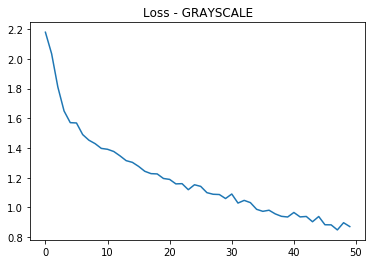

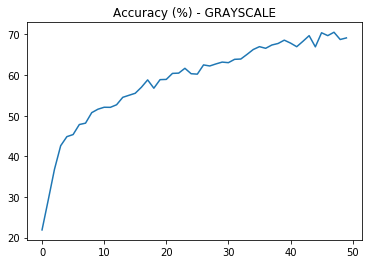

In [0]:
print('VALIDAÇÃO:\n')
plt.title('Loss - GRAYSCALE')
plt.plot(loss_vector)
plt.show()

plt.title('Accuracy (%) - GRAYSCALE')
plt.plot(accuracy_vector)
plt.show()


#Imagens coloridas:

In [0]:
CNN_RGB = CNN(True)
CNN_RGB.to(device)

CNN(
  (conv1): Conv2d(3, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=64, bias=True)
  (drop): Dropout(p=0.6)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (activation_function): ReLU()
)

In [0]:
loss_vector, accuracy_vector = trainCNN(CNN_RGB, train_loader_RGB, 50, 0.001)

Epoch 1 => 	Train_loss: 1.74	Tempo: 60.67s	Acurácia_validação: 54.57%
Epoch 2 => 	Train_loss: 0.66	Tempo: 58.57s	Acurácia_validação: 56.15%
Epoch 3 => 	Train_loss: 1.34	Tempo: 58.23s	Acurácia_validação: 57.32%
Epoch 4 => 	Train_loss: 1.40	Tempo: 59.94s	Acurácia_validação: 59.42%
Epoch 5 => 	Train_loss: 0.52	Tempo: 58.96s	Acurácia_validação: 59.51%
Epoch 6 => 	Train_loss: 0.68	Tempo: 57.80s	Acurácia_validação: 60.10%
Epoch 7 => 	Train_loss: 1.06	Tempo: 59.47s	Acurácia_validação: 61.91%
Epoch 8 => 	Train_loss: 0.68	Tempo: 59.00s	Acurácia_validação: 62.70%
Epoch 9 => 	Train_loss: 1.10	Tempo: 59.18s	Acurácia_validação: 62.82%
Epoch 10 => 	Train_loss: 0.71	Tempo: 57.74s	Acurácia_validação: 64.05%
Epoch 11 => 	Train_loss: 0.80	Tempo: 59.08s	Acurácia_validação: 63.97%
Epoch 12 => 	Train_loss: 1.04	Tempo: 60.77s	Acurácia_validação: 64.27%
Epoch 13 => 	Train_loss: 5.68	Tempo: 59.15s	Acurácia_validação: 62.67%
Epoch 14 => 	Train_loss: 0.87	Tempo: 58.42s	Acurácia_validação: 65.30%
Epoch 15 => 	Tr

In [0]:
testCNN(CNN_RGB, test_loader_RGB)

Acurácia teste: 63.23%


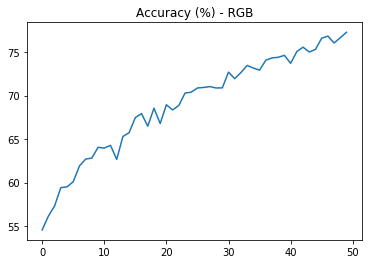

In [0]:
print('VALIDAÇÃO:\n')
plt.title('Loss - RGB')
plt.plot(loss_vector)
plt.show()

plt.title('Accuracy (%) - RGB')
plt.plot(accuracy_vector)
plt.show()


#Conclusões


*   Utilizando apenas um modulo, que consiste em uma camada Convolucional e uma Max Pool, conseguiu um desempenho de 59% de acurácia nas imagens em escala de cinza, e 60% de acurácia nas imagens coloridas.

*   Com o Batch Normalization, os resultados obtidos na validação foram mais próximos aos resultados encontrados na fase de teste, porém demorou bem mais épocas para chegar aos 57%, então, por questão de tempo, optou-se a não utilizar.

*   O melhor learning rate observado foi de lr=0.001, não foi utilizado momentum.

*   Pelos os gráficos,  a tendência é de aumentar e estabilizar a acurácia perto dos 60% na escala de cinza e 63% nas imagens RGB. 

*   Nesta atividade, a rede neural conseguiu com maior êxito classificar as imagens no padrão RGB.


